[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 281140, number of used features: 19
[LightGBM] [Info] Start training from score 16171.769270
Test MAE: 1531.63


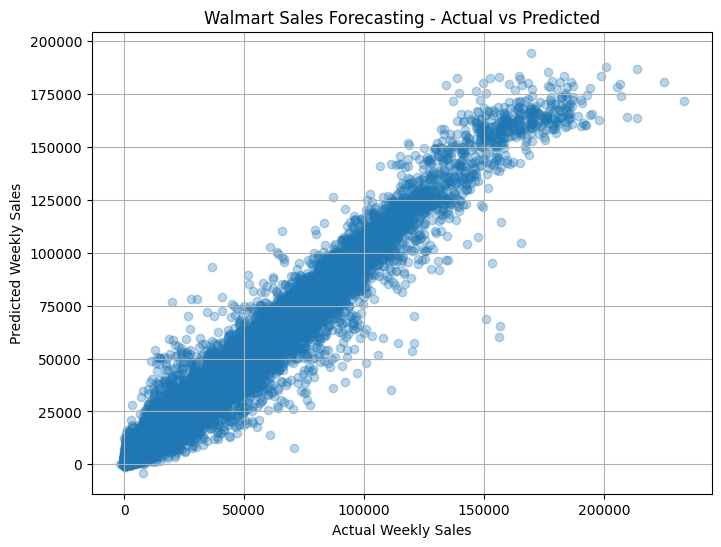

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 2. Load datasets
train = pd.read_csv('train/train.csv', parse_dates=['Date'])
features = pd.read_csv('features/features.csv', parse_dates=['Date'])
stores = pd.read_csv('stores.csv')

# 3. Merge datasets
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

df = train.merge(features, on=['Store', 'Date'], how='left') \
          .merge(stores, on='Store', how='left')

# 4. Handle holiday column conflict
df['is_holiday'] = df['IsHoliday_x'].astype(int)
df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)

# 5. Fill missing markdowns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# 6. Date-based features
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month

# 7. Lagged sales (for demand forecasting)
df = df.sort_values(['Store', 'Dept', 'Date'])
for lag in [1, 2, 4]:
    df[f'sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

df.dropna(inplace=True)

# 8. Feature selection
features_cols = ['Store', 'Dept', 'Size', 'Type', 'Week', 'Month', 'Year', 'is_holiday'] \
              + ['CPI', 'Unemployment'] + markdown_cols \
              + [f'sales_lag_{i}' for i in [1, 2, 4]]

X = pd.get_dummies(df[features_cols], drop_first=True)
y = df['Weekly_Sales']

# 9. Train/test split (temporal split)
train_df = df[df['Date'] < '2012-01-01']
test_df = df[df['Date'] >= '2012-01-01']

X_train = X.loc[train_df.index]
X_test = X.loc[test_df.index]
y_train = y.loc[train_df.index]
y_test = y.loc[test_df.index]

# 10. Model training (LightGBM)
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 11. Predictions and evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

# 12. Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Walmart Sales Forecasting - Actual vs Predicted")
plt.grid(True)
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
import warnings
warnings.filterwarnings('ignore')

# ---- STEP 1: Load and prepare the data ----
# Assuming you have the standard Walmart dataset files
# You'll need to load your data here - example:
# train_df = pd.read_csv('train.csv')
# stores_df = pd.read_csv('stores.csv')
# features_df = pd.read_csv('features.csv')

# For this example, I'll assume df is your merged dataset
# df = train_df.merge(stores_df, on='Store', how='left').merge(features_df, on=['Store', 'Date'], how='left')

# ---- STEP 2: Data preprocessing ----
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create time features
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Handle IsHoliday column (assuming it exists in your dataset)
if 'IsHoliday' in df.columns:
    df['is_holiday'] = df['IsHoliday'].astype(int)
elif 'is_holiday' not in df.columns:
    df['is_holiday'] = 0  # Create dummy holiday column if missing

# Handle Store Type encoding
if 'Type' in df.columns:
    le_type = LabelEncoder()
    df['Type_encoded'] = le_type.fit_transform(df['Type'].fillna('Unknown'))
else:
    df['Type_encoded'] = 0  # Create dummy if missing

# Fill missing values for economic indicators
economic_cols = ['CPI', 'Unemployment']
for col in economic_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Fill missing values for markdowns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)  # Assume 0 markdown if missing
    else:
        df[col] = 0  # Create column if missing

# Ensure Size column exists
if 'Size' not in df.columns:
    df['Size'] = df.groupby('Store')['Store'].transform('count')  # Dummy size based on store frequency

# ---- STEP 3: Feature Engineering ----
# Sort data properly for lag features
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Create lag features
for lag in [1, 2, 3]:
    df[f'sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

# Create rolling statistics
df['sales_mean_4w'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)
df['sales_std_4w'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].rolling(window=4, min_periods=1).std().reset_index(0, drop=True)

# Fill NaN values in rolling stats
df['sales_mean_4w'] = df['sales_mean_4w'].fillna(df['Weekly_Sales'])
df['sales_std_4w'] = df['sales_std_4w'].fillna(0)

# ---- STEP 4: Handle missing values after feature engineering ----
# Drop rows with NaN in lag features (only for training)
initial_rows = len(df)
df_clean = df.dropna(subset=[f'sales_lag_{lag}' for lag in [1, 2, 3]])
print(f"Dropped {initial_rows - len(df_clean)} rows due to missing lag features")

# ---- STEP 5: Select features and target ----
feature_cols = ['Store', 'Dept', 'Size', 'Type_encoded', 'Week', 'Month', 'Year', 'is_holiday',
                'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_mean_4w', 'sales_std_4w']

# Ensure all feature columns exist
existing_features = [col for col in feature_cols if col in df_clean.columns]
print(f"Using features: {existing_features}")

X = df_clean[existing_features].copy()
y = df_clean['Weekly_Sales'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# ---- STEP 6: Split the dataset ----
# Use time-based split
split_date = '2012-01-01'
train_mask = df_clean['Date'] < split_date
test_mask = df_clean['Date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ---- STEP 7: Normalize features ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- STEP 8: Handle target variable ----
# Handle negative sales (if any) before log transform
y_train_positive = np.maximum(y_train, 1)  # Ensure positive values
y_test_positive = np.maximum(y_test, 1)

y_train_log = np.log1p(y_train_positive)
y_test_log = np.log1p(y_test_positive)

# ---- STEP 9: Build the model ----
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# ---- STEP 10: Compile the model ----
model.compile(
    optimizer='adam',
    loss=Huber(delta=1.0),  # robust to outliers
    metrics=['mae']
)

# ---- STEP 11: Train the model ----
print("Training model...")
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=50,
    batch_size=512,
    verbose=1
)

# ---- STEP 12: Predict & Inverse Transform ----
print("Making predictions...")
y_pred_log = model.predict(X_test_scaled, verbose=0).flatten()
y_pred = np.expm1(y_pred_log)  # inverse of log1p

# Ensure predictions are positive
y_pred = np.maximum(y_pred, 0)

# ---- STEP 13: Evaluate ----
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📊 Evaluation Metrics:")
print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"Mean Actual Sales: ${y_test.mean():,.2f}")
print(f"Mean Predicted Sales: ${y_pred.mean():,.2f}")

# ---- STEP 14: Visualizations ----
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
# Actual vs Predicted scatter plot
sample_size = min(1000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
plt.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.5, color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("🧠 Actual vs Predicted Sales")
plt.grid(True)

plt.subplot(1, 3, 3)
# Residuals plot
residuals = y_test.values - y_pred
plt.scatter(y_pred[sample_idx], residuals[sample_idx], alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- STEP 15: Feature Importance (approximate) ----
# Get feature names after preprocessing
feature_names = existing_features

print(f"\n📈 Model Summary:")
print(f"Number of features used: {len(feature_names)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Model parameters: {model.count_params()}")

# Show sample predictions
print(f"\n🔍 Sample Predictions:")
for i in range(5):
    if i < len(y_test):
        print(f"Actual: ${y_test.iloc[i]:,.2f} | Predicted: ${y_pred[i]:,.2f} | Error: ${abs(y_test.iloc[i] - y_pred[i]):,.2f}")

TypeError: incompatible index of inserted column with frame index